#### Example 7 - Refining a triangulation


We have seen how the standard meshes can be uniformly refined to finer resolution. The routines used for this task are available to the `stripy` user for non-uniform refinement as well. 


#### Notebook contents

   - [Uniform meshes](#Uniform-meshes-by-refinement)
   - [Refinement strategies](#Refinement-strategies)
   - [Visualisation](#Visualisation-of-refinement-strategies)
   - [Targetted refinement](#Targetted-refinement)
   - [Visualisation](#Visualisation-of-targetted-refinement)


   

In [1]:
import stripy as stripy
import numpy as np


### Uniform meshes by refinement

The `refinement_level` parameter of the `stripy` meshes makes repeated loops determining the bisection points of all the existing edges in the triangulation and then creating a new triangulation that includes these points and the original ones. These refinement operations can also be used for non-uniform refinement. 

In [2]:
ico0 = stripy.spherical_meshes.icosahedral_mesh(refinement_levels=0)
ico1 = stripy.spherical_meshes.icosahedral_mesh(refinement_levels=1)
ico2 = stripy.spherical_meshes.icosahedral_mesh(refinement_levels=2)
ico3 = stripy.spherical_meshes.icosahedral_mesh(refinement_levels=3)
ico4 = stripy.spherical_meshes.icosahedral_mesh(refinement_levels=4)
ico5 = stripy.spherical_meshes.icosahedral_mesh(refinement_levels=5)
ico6 = stripy.spherical_meshes.icosahedral_mesh(refinement_levels=6)
ico7 = stripy.spherical_meshes.icosahedral_mesh(refinement_levels=7)

print("Size of mesh - 1  {}".format(ico1.points.shape[0]))
print("Size of mesh - 2  {}".format(ico2.points.shape[0]))
print("Size of mesh - 3  {}".format(ico3.points.shape[0]))
print("Size of mesh - 4  {}".format(ico4.points.shape[0]))
print("Size of mesh - 5  {}".format(ico5.points.shape[0]))
print("Size of mesh - 6  {}".format(ico6.points.shape[0]))
print("Size of mesh - 7  {}".format(ico7.points.shape[0]))


Size of mesh - 1  42
Size of mesh - 2  162
Size of mesh - 3  642
Size of mesh - 4  2562
Size of mesh - 5  10242
Size of mesh - 6  40962
Size of mesh - 7  163842


### Refinement strategies

Five refinement strategies:

   - Bisect all segments connected to a given node
   - Refine all triangles connected to a given node by adding a point at the centroid or bisecting all edges
   - Refune a given triangle by adding a point at the centroid or bisecting all edges
   
These are provided as follows:

In [4]:

mlons, mlats = ico3.midpoint_refine_triangulation_by_vertices(vertices=[1,2,3,4,5,6,7,8,9,10])
ico3mv = stripy.sTriangulation(mlons, mlats)

mlons, mlats = ico3.edge_refine_triangulation_by_vertices(vertices=[1,2,3,4,5,6,7,8,9,10])
ico3ev = stripy.sTriangulation(mlons, mlats)

mlons, mlats = ico3.centroid_refine_triangulation_by_vertices(vertices=[1,2,3,4,5,6,7,8,9,10])
ico3cv = stripy.sTriangulation(mlons, mlats)

mlons, mlats = ico3.edge_refine_triangulation_by_triangles(triangles=[1,2,3,4,5,6,7,8,9,10])
ico3et = stripy.sTriangulation(mlons, mlats)

mlons, mlats = ico3.centroid_refine_triangulation_by_triangles(triangles=[1,2,3,4,5,6,7,8,9,10])
ico3ct = stripy.sTriangulation(mlons, mlats)


print (ico3mv.npoints, ico3mv.simplices.shape[0])
print (ico3ev.npoints, ico3ev.simplices.shape[0])
print (ico3cv.npoints, ico3cv.simplices.shape[0])
print (ico3et.npoints, ico3et.simplices.shape[0])
print (ico3ct.npoints, ico3ct.simplices.shape[0])


692 1380
742 1480
692 1380
664 1324
652 1300


### Visualisation of refinement strategies


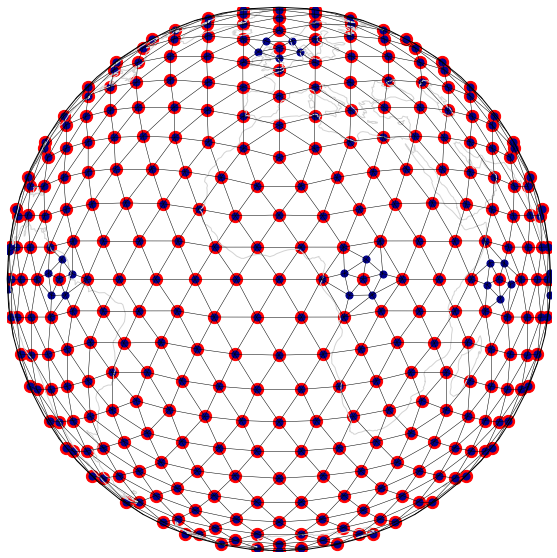

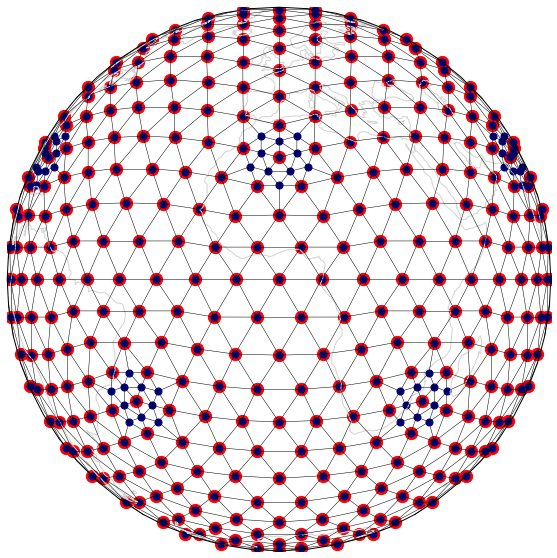

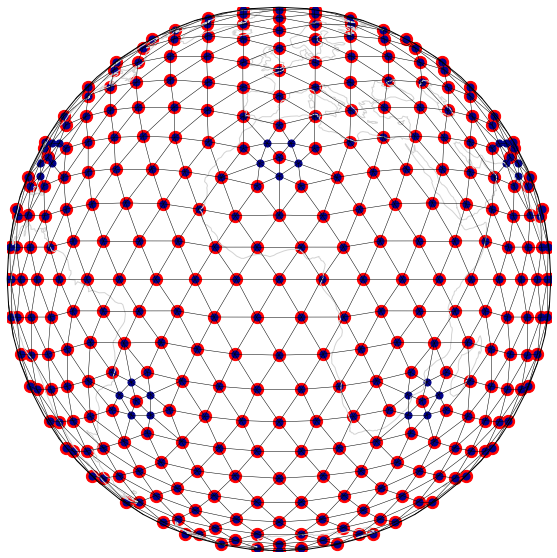

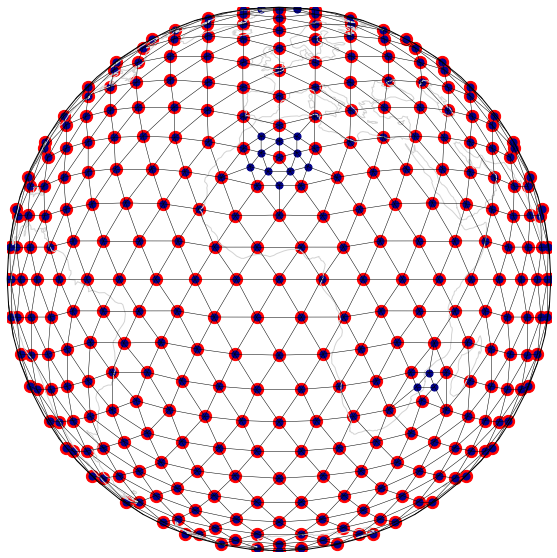

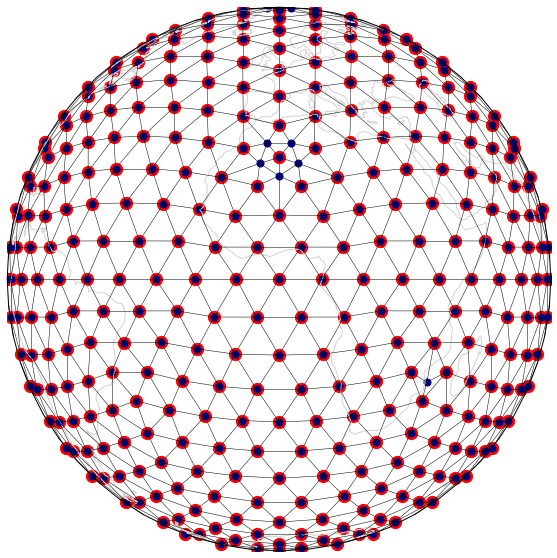

In [5]:
import matplotlib.pyplot as plt

%matplotlib inline

import gdal



import cartopy
import cartopy.crs as ccrs

def mesh_fig(mesh, meshR, name):

    fig = plt.figure(figsize=(10, 10), facecolor="none")
    ax  = plt.subplot(111, projection=ccrs.Orthographic(central_longitude=0.0, central_latitude=0.0, globe=None))
    ax.coastlines(color="lightgrey")
    ax.set_global()

    generator = mesh
    refined   = meshR

    lons0 = np.degrees(generator.lons)
    lats0 = np.degrees(generator.lats)

    lonsR = np.degrees(refined.lons)
    latsR = np.degrees(refined.lats)

    lst = refined.lst
    lptr = refined.lptr


    ax.scatter(lons0, lats0, color="Red",
                marker="o", s=150.0, transform=ccrs.Geodetic())

    ax.scatter(lonsR, latsR, color="DarkBlue",
                marker="o", s=50.0, transform=ccrs.Geodetic())


    segs = refined.identify_segments()

    for s1, s2 in segs:
        ax.plot( [lonsR[s1], lonsR[s2]],
                 [latsR[s1], latsR[s2]], 
                 linewidth=0.5, color="black", transform=ccrs.Geodetic())

    fig.savefig(name, dpi=250, transparent=True)
    
    return


mesh_fig(ico3,        ico3mv,     "EdgeByVertex1to10" )
mesh_fig(ico3,        ico3ev,     "EdgeByVertexT1to10" )
mesh_fig(ico3,        ico3cv,     "CentroidByVertexT1to10" )
mesh_fig(ico3,        ico3et,     "EdgeByTriangle1to10" )
mesh_fig(ico3,        ico3ct,     "CentroidByTriangle1to10" )



### Targetted refinement

Here we refine a triangulation to a specific criterion - resolving two points in distinct triangles or with distinct nearest neighbour vertices. 

In [6]:
points = np.array([[ 0.03, 0.035], [0.05, 0.055]]).T

In [8]:
triangulations = [ico1]
nearest, distances = triangulations[-1].nearest_vertex(points[:,0], points[:,1])

max_depth = 15

while nearest[0] == nearest[1] and max_depth > 0:

    lons, lats = triangulations[-1].centroid_refine_triangulation_by_vertices(vertices=nearest[0])
    new_triangulation = stripy.sTriangulation(lons, lats)
    nearest, distances = new_triangulation.nearest_vertex(points[:,0], points[:,1])
    triangulations.append(new_triangulation)
    
    max_depth -= 1

print ("refinement_steps =", len(triangulations))

centroid_triangulations = triangulations[:]

refinement_steps = 5


In [10]:
triangulations = [ico1]
nearest, distances = triangulations[-1].nearest_vertex(points[:,0], points[:,1])

max_depth = 15

while nearest[0] == nearest[1] and max_depth > 0:

    lons, lats = triangulations[-1].edge_refine_triangulation_by_vertices(vertices=nearest[0])
    new_triangulation = stripy.sTriangulation(lons, lats)
    nearest, distances = new_triangulation.nearest_vertex(points[:,0], points[:,1])
    triangulations.append(new_triangulation)
    
    max_depth -= 1

print ("refinement_steps =", len(triangulations))

edge_triangulations = triangulations[:]

refinement_steps = 6


In [12]:
triangulations = [ico1]

in_triangle = triangulations[-1].containing_triangle(points[:,0], points[:,1])

max_depth = 100

while in_triangle[0] == in_triangle[1] and max_depth > 0:

    lons, lats = triangulations[-1].edge_refine_triangulation_by_triangles(in_triangle[0])
    new_triangulation = stripy.sTriangulation(lons, lats)
    in_triangle = new_triangulation.containing_triangle(points[:,0], points[:,1])
    triangulations.append(new_triangulation)
    
    print (in_triangle)


    
    if in_triangle.shape[0] == 0:
        break
    
    max_depth -= 1

print ("refinement_steps =", len(triangulations))

edge_t_triangulations = triangulations[:]

[85 85]
[90 90]
[92 92]
[102 102]
[104 104]
[111 106]
refinement_steps = 7


In [13]:
triangulations = [ico1]

in_triangle = triangulations[-1].containing_triangle(points[:,0], points[:,1])

max_depth = 100

while in_triangle[0] == in_triangle[1] and max_depth > 0:

    lons, lats = triangulations[-1].centroid_refine_triangulation_by_triangles(in_triangle[0])
    new_triangulation = stripy.sTriangulation(lons, lats)
    in_triangle = new_triangulation.containing_triangle(points[:,0], points[:,1])
    triangulations.append(new_triangulation)
    
    print (in_triangle)
    
    if in_triangle.shape[0] == 0:
        break
    
    max_depth -= 1

print ("refinement_steps =", len(triangulations))

centroid_t_triangulations = triangulations[:]

[63 63]
[70 70]
[85 85]
[64 64]
[87 87]
[91 91]
[92 92]
[92 92]
[96 96]
[99 97]
refinement_steps = 11


### Visualisation of targetted refinement


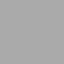

In [14]:
import lavavu

## The four different triangulation strategies

t1 = edge_triangulations[-1]
t2 = edge_t_triangulations[-1]
t3 = centroid_triangulations[-1]
t4 = centroid_t_triangulations[-1]

## Fire up the viewer 

lv = lavavu.Viewer(border=False, background="#FFFFFF", resolution=[1000,600], near=-10.0)

## Add the nodes to mark the original triangulation

nodes = lv.points("nodes", pointsize=10.0, pointtype="shiny", colour="#448080", opacity=0.75)
nodes.vertices(ico1.points*1.01)
nodes2 = lv.points("SplitPoints", pointsize=2.0, pointtype="shiny", colour="#FF3300", opacity=1.0) 
nodes2.vertices(np.array(stripy.spherical.lonlat2xyz(points[:,0], points[:,1])).T * 1.01)

## 

tris1w = lv.triangles("t1w",  wireframe=True, colour="#444444", opacity=0.8)
tris1w.vertices(t1.points)
tris1w.indices(t1.simplices)

tris1s = lv.triangles("t1s",  wireframe=False, colour="#77ff88", opacity=0.8)
tris1s.vertices(t1.points*0.999)
tris1s.indices(t1.simplices)

tris2w = lv.triangles("t2w",  wireframe=True, colour="#444444", opacity=0.8)
tris2w.vertices(t2.points)
tris2w.indices(t2.simplices)

tris2s = lv.triangles("t2s",  wireframe=False, colour="#77ff88", opacity=0.8)
tris2s.vertices(t2.points*0.999)
tris2s.indices(t2.simplices)

tris3w = lv.triangles("t3w",  wireframe=True, colour="#444444", opacity=0.8)
tris3w.vertices(t3.points)
tris3w.indices(t3.simplices)

tris3s = lv.triangles("t3s",  wireframe=False, colour="#77ff88", opacity=0.8)
tris3s.vertices(t3.points*0.999)
tris3s.indices(t3.simplices)

tris4w = lv.triangles("t4w",  wireframe=True, colour="#444444", opacity=0.8)
tris4w.vertices(t4.points)
tris4w.indices(t4.simplices)

tris4s = lv.triangles("t4s",  wireframe=False, colour="#77ff88", opacity=0.8)
tris4s.vertices(t4.points*0.999)
tris4s.indices(t4.simplices)

lv.hide("t1s")
lv.hide("t1w")
lv.hide("t2s")
lv.hide("t2w")
lv.hide("t4s")
lv.hide("t4w")

lv.translation(0.0, 0.0, -3.748)
lv.rotation(37.5, -90.0, -37.5)

lv.control.Panel()
lv.control.Button(command="hide triangles; show t1s; show t1w; redraw", label="EBV")
lv.control.Button(command="hide triangles; show t2s; show t2w; redraw", label="EBT")
lv.control.Button(command="hide triangles; show t3s; show t3w; redraw", label="CBV")
lv.control.Button(command="hide triangles; show t4s; show t4w; redraw", label="CBT")
lv.control.show()


EBV 200 4.540084060033637 1.0 35.2792941304391
EBT 116 32.054115598497226 1.0 69.2676258759991
CBV 126 2.89224779940056 1.0 11.691555217729436
CBT 100 3.4282922914052634 1.0 32.74941535804814


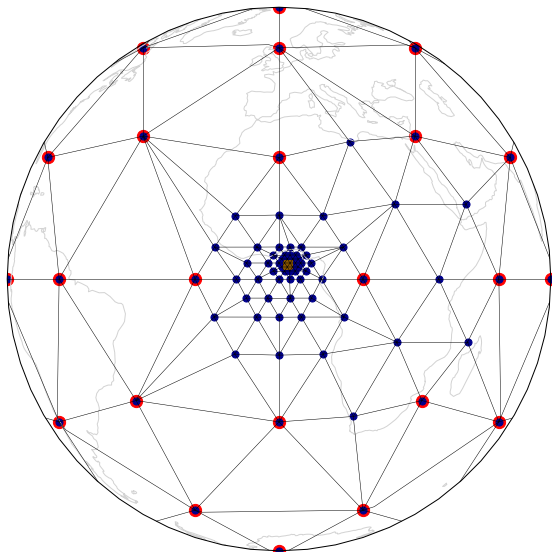

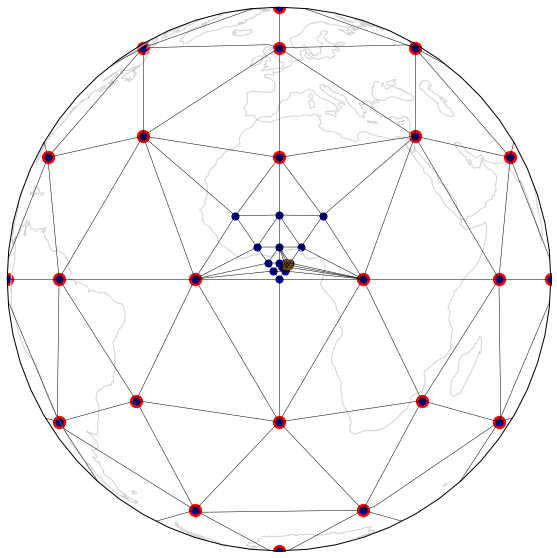

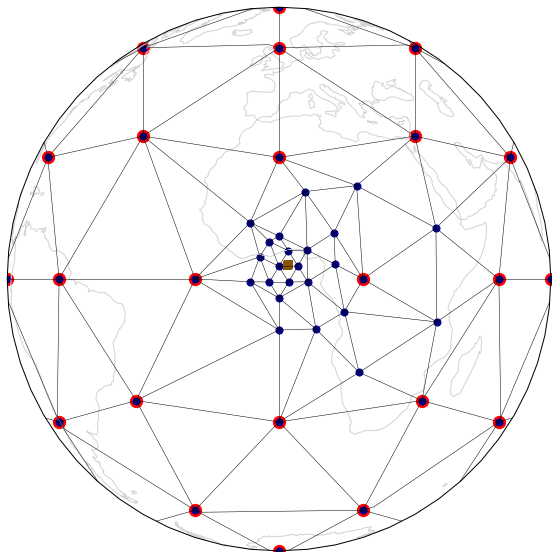

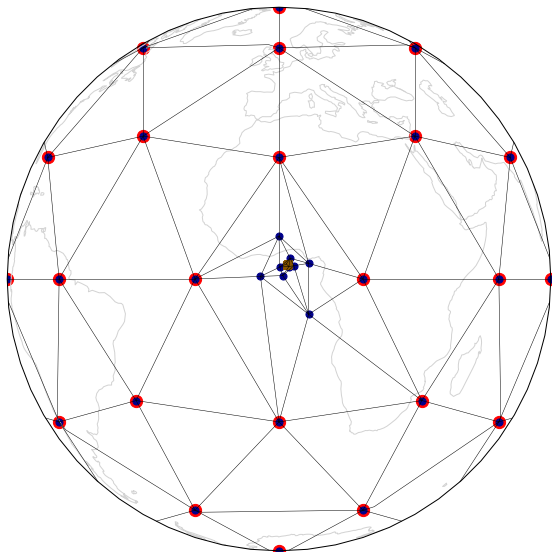

In [16]:
import matplotlib.pyplot as plt

%matplotlib inline

import gdal



import cartopy
import cartopy.crs as ccrs

def mesh_fig(mesh, meshR, name):

    fig = plt.figure(figsize=(10, 10), facecolor="none")
    ax  = plt.subplot(111, projection=ccrs.Orthographic(central_longitude=0.0, central_latitude=0.0, globe=None))
    ax.coastlines(color="lightgrey")
    ax.set_global()

    generator = mesh
    refined   = meshR

    lons0 = np.degrees(generator.lons)
    lats0 = np.degrees(generator.lats)

    lonsR = np.degrees(refined.lons)
    latsR = np.degrees(refined.lats)


    ax.scatter(lons0, lats0, color="Red",
                marker="o", s=150.0, transform=ccrs.Geodetic())

    ax.scatter(lonsR, latsR, color="DarkBlue",
                marker="o", s=50.0, transform=ccrs.Geodetic())

    ax.scatter(np.degrees(points[:,0]), np.degrees(points[:,1]), marker="s", s=50, 
               color="#885500", transform=ccrs.Geodetic())

    segs = refined.identify_segments()

    for s1, s2 in segs:
        ax.plot( [lonsR[s1], lonsR[s2]],
                 [latsR[s1], latsR[s2]], 
                 linewidth=0.5, color="black", transform=ccrs.Geodetic())

    fig.savefig(name, dpi=250, transparent=True)
    
    return



mesh_fig(edge_triangulations[0],        edge_triangulations[-1],     "EdgeByVertex" )

T = edge_triangulations[-1]
E = np.array(T.edge_lengths()).T
A = np.array(T.areas()).T
equant = np.max(E, axis=1) / np.min(E, axis=1)
size_ratio = np.sqrt(np.max(A) / np.min(A))
print ("EBV", T.simplices.shape[0], equant.max(), equant.min(), size_ratio)

mesh_fig(edge_t_triangulations[0],      edge_t_triangulations[-1],     "EdgeByTriangle" )


T = edge_t_triangulations[-1]
E = np.array(T.edge_lengths()).T
A = np.array(T.areas()).T
equant = np.max(E, axis=1) / np.min(E, axis=1)
size_ratio = np.sqrt(np.max(A) / np.min(A))
print ("EBT", T.simplices.shape[0], equant.max(), equant.min(), size_ratio)


mesh_fig(centroid_triangulations[0],    centroid_triangulations[-1],   "CentroidByVertex" )

T = centroid_triangulations[-1]
E = np.array(T.edge_lengths()).T
A = np.array(T.areas()).T
equant = np.max(E, axis=1) / np.min(E, axis=1)
size_ratio = np.sqrt(np.max(A) / np.min(A))
print ("CBV", T.simplices.shape[0], equant.max(), equant.min(), size_ratio)



mesh_fig(centroid_t_triangulations[0],  centroid_t_triangulations[-1], "CentroidByTriangle" )

T = centroid_t_triangulations[-1]
E = np.array(T.edge_lengths()).T
A = np.array(T.areas()).T
equant = np.max(E, axis=1) / np.min(E, axis=1)
size_ratio = np.sqrt(np.max(A) / np.min(A))
print ("CBT", T.simplices.shape[0], equant.max(), equant.min(), size_ratio)




